In [ ]:
import tensorflow as tf, cv2, albumentations as A, os, numpy as np, matplotlib.pyplot as plt, skimage
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Conv2DTranspose
from keras.models import Model, load_model
from keras.utils import image_dataset_from_directory, plot_model
from keras.losses import Dice, Tversky
from keras.callbacks import ReduceLROnPlateau as RLR, ModelCheckpoint
from keras.metrics import IoU
from sklearn.model_selection import train_test_split
from scipy import ndimage
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

2025-05-08 17:20:04.726469: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 17:20:04.809222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-08 17:20:04.830692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-08 17:20:04.837645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 17:20:04.919535: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.getcwd()

'/mnt/d/Work/UCSD/Senior_year/Senior_design'

### Setting up model

In [3]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

# Function to apply augmentations dynamically
def augment_on_the_fly(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

/root/anaconda3/envs/AI_training/lib/python3.12/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
# Data generator for on-the-fly augmentation
def data_generator(image_paths, mask_paths, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_paths))):
                # Load image and mask
                image = cv2.imread(image_paths[j], cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_paths[j], cv2.IMREAD_GRAYSCALE)

                # Resize to match input shape
                image = cv2.resize(image, (512, 512))
                mask = cv2.resize(mask, (512, 512))

                # Apply augmentation
                aug_image, aug_mask = augment_on_the_fly(image, mask)

                # Normalize
                aug_image = aug_image / 255.0
                aug_mask = aug_mask[..., np.newaxis] / 255.0  # Add channel dimension

                batch_images.append(aug_image)
                batch_masks.append(aug_mask)

            yield np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

In [5]:
# Lighter Model
# Define a lighter convolutional block
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = BatchNormalization()(x)
    return x

# Define an encoder block
def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

# Define a decoder block
def decoder_block(inputs, skip_features, filters):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, filters)
    return x

# Define a lighter Multi-Scale U-Net model
def multi_scale_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder path
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = conv_block(p4, 512)

    # Decoder path
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    # Model
    model = Model(inputs, outputs, name="Lighter-Multi-Scale-U-Net")
    return model

# Instantiate the model
input_shape = (512, 512, 3)
model = multi_scale_unet(input_shape, num_classes)

def weighted_binary_crossentropy(pos_weight, neg_weight):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        loss = - (pos_weight * y_true * tf.math.log(y_pred) +
                  neg_weight * (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(loss)
    return loss_fn

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=weighted_binary_crossentropy(1.0,1.0),
              metrics=['accuracy'])

# Display the model summary
model.summary()

I0000 00:00:1746750019.542215    6670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746750019.838647    6670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746750019.838746    6670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746750019.845678    6670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746750019.845735    6670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "Lighter-Multi-Scale-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 3,838,497 (14.64 MB)

 Trainable params: 3,835,553 (14.63 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Loading images

In [1]:
image_prefix, mask_prefix = "original/", "mask_processed/"
mp, ip = [mask_prefix + n for n in sorted(os.listdir(mask_prefix))], [image_prefix + n for n in sorted(os.listdir(image_prefix))]

NameError: name 'os' is not defined

In [18]:
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    ip, mp, test_size=0.2, random_state=42
)


In [ ]:
# ckpt = ModelCheckpoint(filepath = "../Tversky_82_best.keras", save_best_only = True, monitor = "val_accuracy")

In [ ]:
# Before training, make sure whether to save the model or not
batch_size = 15

train_gen = data_generator(train_image_paths, train_mask_paths, batch_size)
test_gen = data_generator(test_image_paths, test_mask_paths, batch_size)

steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(test_image_paths) // batch_size

history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=50, validation_data=test_gen, validation_steps=validation_steps, callbacks = [RLR(factor = 0.1, patience = 5, min_lr = 1e-7)], verbose = 1)

Epoch 1/50


I0000 00:00:1740865549.856031    3083 service.cc:146] XLA service 0x7f4d5400aef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740865549.856066    3083 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-01 13:45:49.917738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-01 13:45:50.172272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
2025-03-01 13:45:52.117605: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-01 13:45:52.511486: W external/local_tsl/tsl/framework/bfc_allocator.cc

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4264 - loss: 1.0121

2025-03-01 13:46:10.906309: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-01 13:46:11.202684: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 711ms/step - accuracy: 0.4353 - loss: 0.9983 - val_accuracy: 0.4469 - val_loss: 0.6965 - learning_rate: 1.0000e-04
Epoch 2/50


2025-03-01 13:46:14.369540: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-01 13:46:14.597590: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-01 13:46:18.954663: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-01 13:46:19.159743: W external/local_tsl/tsl/framework/b

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - accuracy: 0.7805 - loss: 0.5089 - val_accuracy: 0.4801 - val_loss: 0.6959 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.8729 - loss: 0.3644 - val_accuracy: 0.6574 - val_loss: 0.6800 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.9130 - loss: 0.2846 - val_accuracy: 0.7427 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.9261 - loss: 0.2552 - val_accuracy: 0.8151 - val_loss: 0.6314 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.9343 - loss: 0.2211 - val_accuracy: 0.8515 - val_loss: 0.5970 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9387 - loss: 0.2007 - val_accuracy: 0.8514 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.9374 - l

### Model Evaluation

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall']
    
    plt.figure(figsize=(15, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


plot_metrics(history)

In [ ]:
# Load and preprocess test data for visualization
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0

        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

test_imgs, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)
mask_pred = model.predict(test_imgs)

fpr, tpr, _ = roc_curve(test_masks, mask_pred)
auc_score = roc_auc_score(test_masks, mask_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pixel-wise ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [20]:
# Visualization of predictions
def visualize_predictions(model, test_images, test_masks, num_examples=3):
    predictions = model.predict(test_images)
    threshold = 0.5
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i])

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(test_masks[i].squeeze(), cmap='gray')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        binary_pred_mask = (predictions[i] > threshold).astype(np.float32)
        plt.imshow(binary_pred_mask.squeeze(), cmap='gray')

        plt.show()

# Load and preprocess test data for visualization
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0

        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

In [21]:
# model = load_model("../Tversky_82_best.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step 


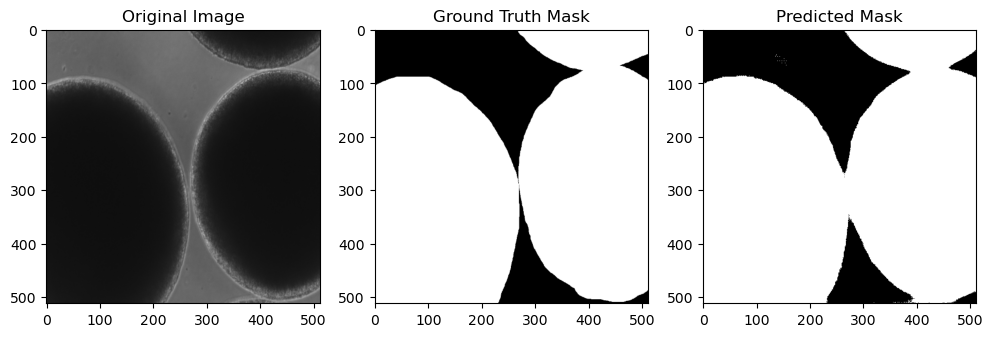

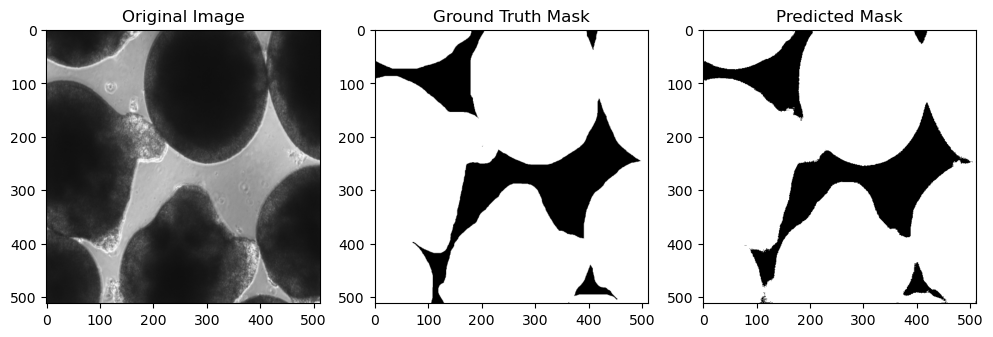

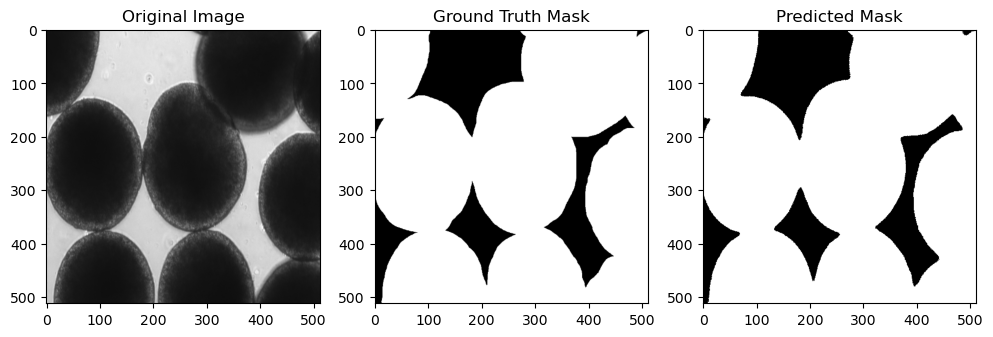

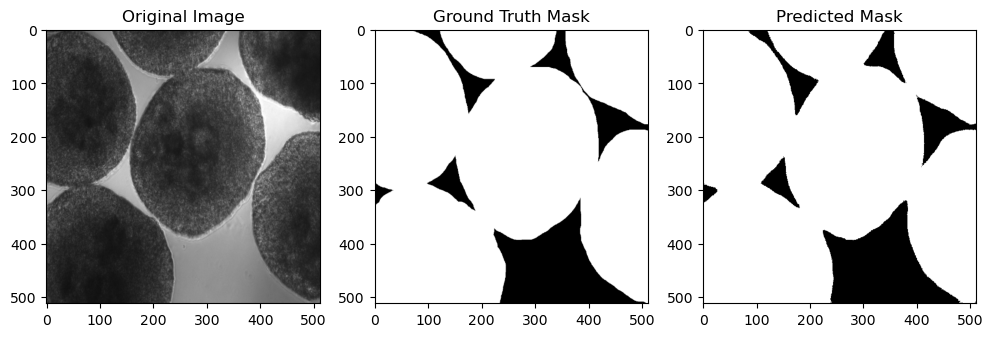

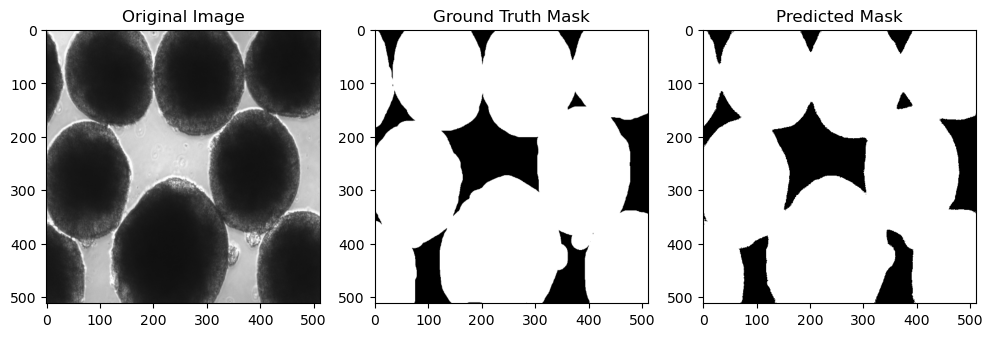

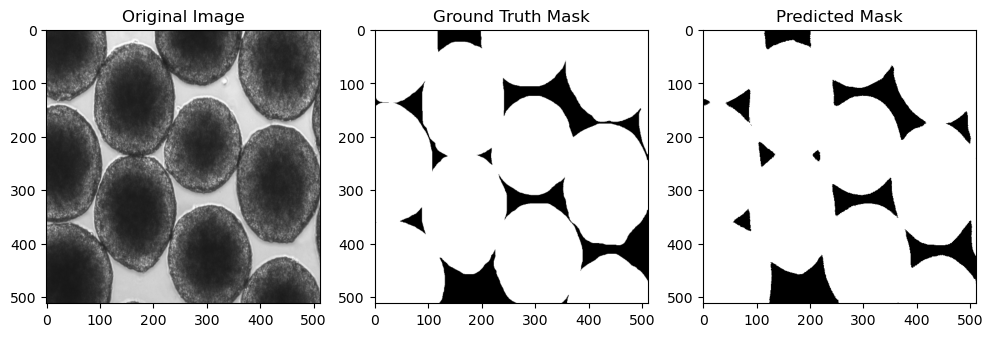

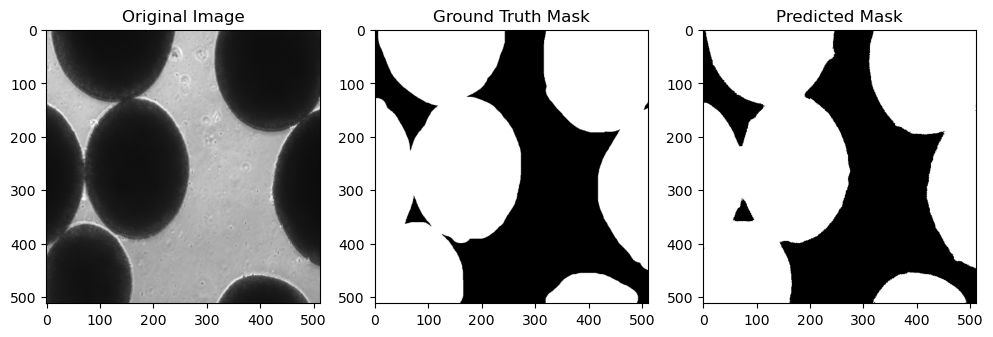

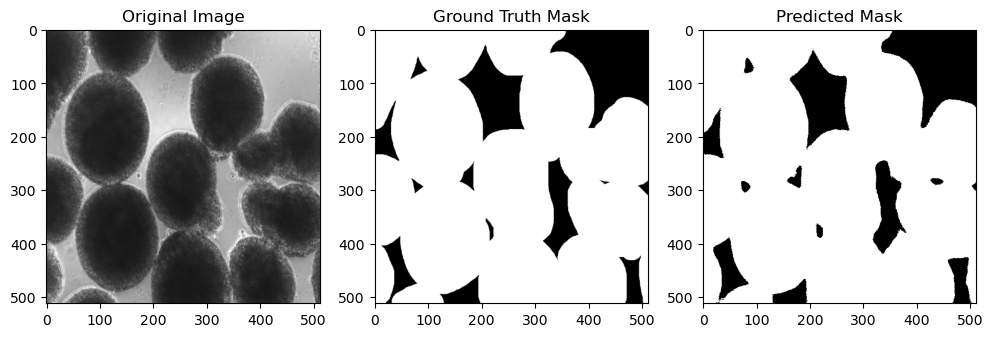

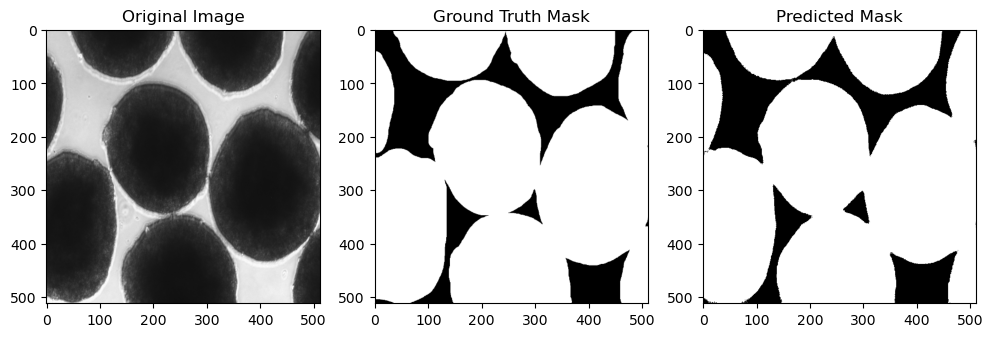

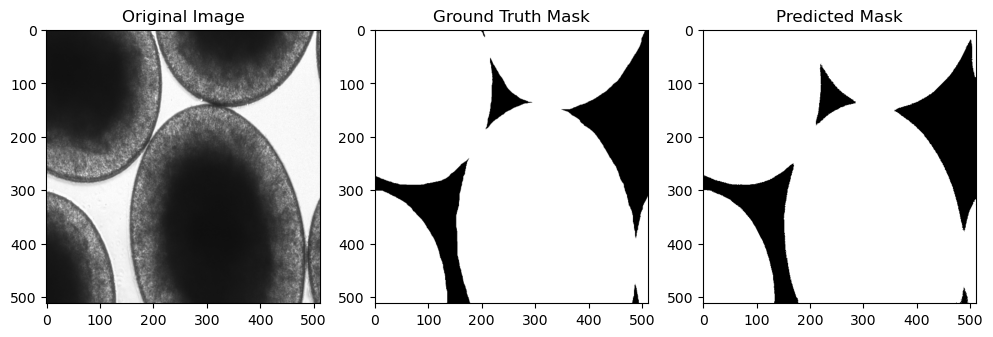

In [22]:
# Example usage for visualization
num_examples = 10
test_images, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)
visualize_predictions(model, test_images, test_masks, num_examples)

In [ ]:
model.save("../AI_models/MS_Unet_Lite_2.keras")

### Batch Segmentations

In [ ]:
model = load_model("../AI_models/MS_Unet_Lite_2.keras")

In [ ]:
def vis_pred_no_ground(test_images, predictions, example_idx):
    threshold = 0.5
    for i in example_idx:
        if i > 39:
          continue
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i])


        # Predicted Mask
        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        binary_pred_mask = (predictions[i] > threshold).astype(np.float32)
        plt.imshow(binary_pred_mask.squeeze(), cmap='gray')

        plt.show()

In [ ]:
test_img_dir = "test/"

In [ ]:
def load_images(image_dir,input_shape=(512, 512)):
    test_images = []
    for img_path in os.listdir(image_dir):
        img_path = image_dir + img_path
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0
        test_images.append(image)

    return np.array(test_images, dtype=np.float32)

In [ ]:
test_img_new = load_images(test_img_dir)

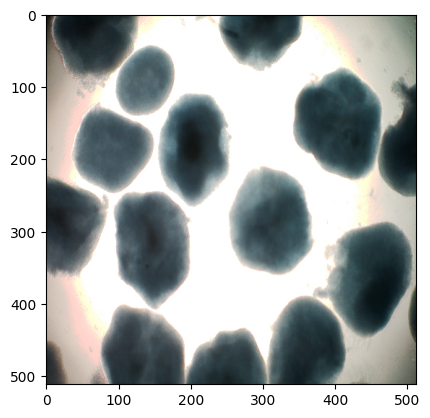

In [ ]:
plt.imshow(test_img_new[0])

In [ ]:
pred_new = model.predict(test_img_new)

2/2 ━━━━━━━━━━━━━━━━━━━━ 63s 17s/step


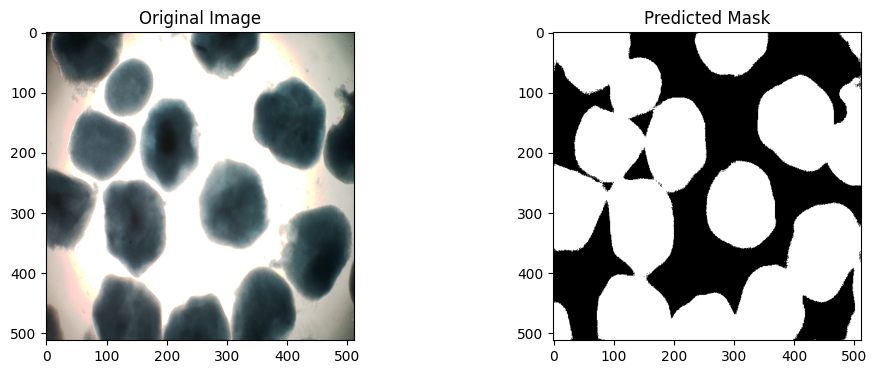

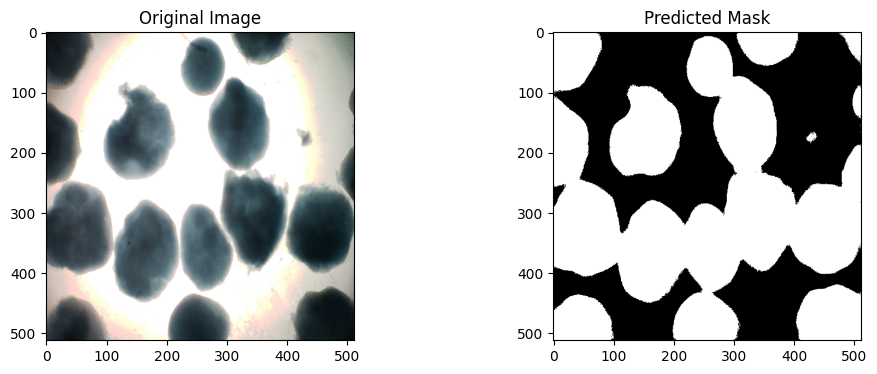

In [ ]:
vis_pred_no_ground(test_img_new, pred_new, [0,1])

In [ ]:
def seg_pipe(images: np.ndarray, pred: np.ndarray):
  seg_images = np.zeros_like(images)
  b,h,w,c = images.shape
  cell_data = list()
  for i in range(b):
    img, p = images[i], pred[i]
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.uint8)

    # Normalize and convert
    p = cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX)
    p = p.astype(np.uint8)

    # Thresholding
    _, thresh = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Morphological opening
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 4)

    # Dilation to determine sure background
    sure_bg = cv2.dilate(opening, kernel, iterations = 8)

    # Distance transformation
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    # Determine sure foreground
    _, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)

    # Define unknown areas
    sure_fg = np.uint8(sure_fg)
    unk = cv2.subtract(sure_bg, sure_fg)

    # Define markers and set unknown areas = 0
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 10
    markers[unk == 255] = 0

    # Perform Watershed
    markers = cv2.watershed(img,markers)

    # Create color labeled images
    seg_img = skimage.color.label2rgb(markers, bg_label = 0)
    seg_images[i] = seg_img

    # Morphological measurements
    properties = ["label", "area", "centroid"]
    props = skimage.measure.regionprops_table(markers, intensity_image = img_grey, properties = properties)
    df = pd.DataFrame(props)
    cell_data.append(df)

  return seg_images, cell_data

In [ ]:
seg_images, cell_data = seg_pipe(test_img_new, pred_new)

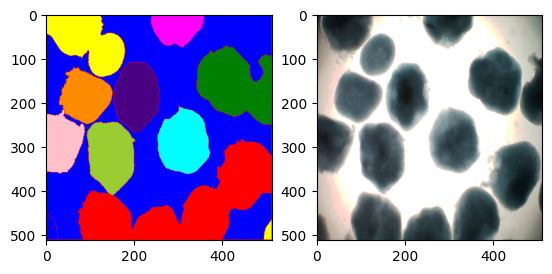

In [ ]:
num = 0
plt.subplot(1,2,1)
plt.imshow(seg_images[num])

plt.subplot(1,2,2)
plt.imshow(test_img_new[num])

plt.show()

In [ ]:
cell_data[num]

,label,area,centroid-0,centroid-1
0,10,109448.0,242.100861,267.144233
1,11,15754.0,61.172972,93.157674
2,12,6669.0,30.736542,295.450892
3,13,20662.0,160.029571,429.746636
4,14,12197.0,185.114946,204.959088
5,15,10322.0,185.987502,88.017923
6,16,13403.0,289.823472,311.511154
7,17,9070.0,291.412679,36.636494
8,18,13659.0,319.285672,146.352295
9,19,43337.0,429.259870,317.948474
